<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/allocationoilandgas2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setting up the Colab page to use neqsim
#@markdown <br><br>This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
%%capture
!pip install neqsim==3.0.13
import neqsim
from neqsim.thermo.thermoTools import *

# Introduction

This Colab notebook demonstrates how to use the NeqSim process simulation library to perform **allocation calculations** for oil and gas production. Allocation is the process of determining the contribution of individual wells or streams to the total production of a field. This is important for accounting purposes and for optimizing production.

The notebook first defines a simple process flow diagram consisting of two wells, a separator, and an export pipeline. The process is simulated using NeqSim, and the results are used to calculate **Oil Recovery Factors (ORF)** for each well. The ORF is the fraction of the oil in the well stream that is recovered in the separator.

The notebook then demonstrates how to track individual components from each well through the process. This allows for a more detailed analysis of the allocation results.

Finally, the notebook explores the impact of different production rates on the allocation results. This shows how changes in production can affect the allocation of oil and gas to individual wells.

In addition to demonstrating the use of NeqSim for allocation calculations, the notebook provides a brief overview of the allocation process and its importance in the petroleum industry.

# Litterature

Recommended guideline for allocation simulation

https://openarchive.usn.no/usn-xmlui/handle/11250/2765116

Production Allocation of Oil and Gas: A case Study:

https://ntnuopen.ntnu.no/ntnu-xmlui/handle/11250/2351061


Energy Institute

https://publishing.energyinst.org/topics/hydrocarbon-management/upstream-measurement/hm-96.-guidelines-for-the-allocation-of-fluid-streams-in-oil-and-gas-production

#Allocation of oil and gas

https://en.wikipedia.org/wiki/Allocation_(oil_and_gas)


In the petroleum industry, allocation refers to practices of breaking down measures of quantities of extracted hydrocarbons across various contributing sources. Allocation aids the attribution of ownerships of hydrocarbons as each contributing element to a commingled flow or to a storage of petroleum may have a unique ownership. Contributing sources in this context are typically producing petroleum wells delivering flows of petroleum or flows of natural gas to a commingled flow or storage.

The terms hydrocarbon accounting and allocation are sometimes used interchangeably. Hydrocarbon accounting has a wider scope, taking advantages of allocation results, it is the petroleum management process by which ownership of extracted hydrocarbons is determined and tracked from a point of sale or discharge back to the point of extraction. In this way, hydrocarbon accounting also covers inventory control, material balance, and practices to trace ownership of hydrocarbons being transported in a transportation system, e.g. through pipelines to customers distant from the production plant.

In an allocation problem, contributing sources are more widely natural gas streams, fluid flows or multiphase flows derived from formations or zones in a well, from wells, and from fields, unitised production entities or production facilities. In hydrocarbon accounting, quantities of extracted hydrocarbon can be further split by ownership, by "cost oil" or "profit oil" categories, and broken down to individual composition fraction types. Such components may be alkane hydrocarbons, boiling point fractions, and mole weight fractions.



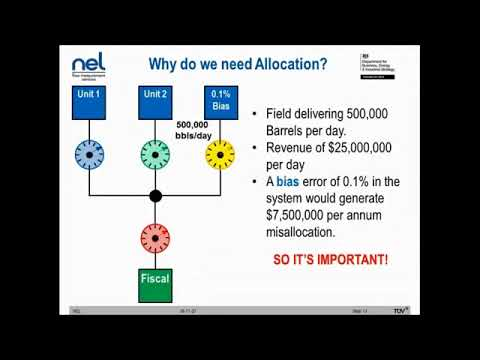

In [2]:
#@title Introduction to Allocation
#@markdown This video gives an intriduction to allocation of oil and gas
from IPython.display import YouTubeVideo
YouTubeVideo('pdIzRGTgmco', width=600, height=400)

# Process simulation for allocation

In [3]:
inputdata = {
  'feedFlowRateWellA': 10,
  'wellPressure': 280.0,
  'wellTemperature':200.0,
  'topsidePressure': 90.0,
  'topsideTemperature': 5.0,
  'firstStagePressure': 75.0,
  'temperatureOilHeater' : 90.0,
  'secondStagePressure': 8.6,
  'thirdStagePressure': 1.9,
  'firstStageSuctionCoolerTemperature': 25.3,
  'secondStageSuctionCoolerTemperature': 24.5,
  'thirdStageSuctionCoolerTemperature':25.0,
  'firstStageExportCoolerTemperature': 25.3,
  'secondStageExportCoolerTemperature': 24.5
}

In [4]:
from neqsim.thermo import fluid, printFrame
from neqsim.process import compressor, cooler, separator3phase, getProcess, clearProcess, mixer, heater, stream, pump, separator, runProcess, stream, saturator, valve, filters, heatExchanger, simpleTEGAbsorber,distillationColumn, waterStripperColumn, recycle, setpoint, calculator

clearProcess()

wellFluid = fluid('pr')
wellFluid.addComponent("nitrogen", 0.08)
wellFluid.addComponent("CO2", 3.56)
wellFluid.addComponent("methane", 87.36)
wellFluid.addComponent("ethane", 4.02)
wellFluid.addComponent("propane", 1.54)
wellFluid.addComponent("i-butane", 0.2)
wellFluid.addComponent("n-butane", 0.42)
wellFluid.addComponent("i-pentane", 0.15)
wellFluid.addComponent("n-pentane", 0.20)

wellFluid.addTBPfraction("C6", 3.24, 84.99/1000.0, 695.0/1000.0)
wellFluid.addTBPfraction("C7", 1.34, 97.87/1000.0, 718.0/1000.0)
wellFluid.addTBPfraction("C8", 1.33, 111.54/1000.0, 729.0/1000.0)
wellFluid.addTBPfraction("C9", 1.19, 126.1/1000.0, 749.0/1000.0)
wellFluid.addTBPfraction("C10", 1.15, 140.14/1000.0, 760.0/1000.0)
wellFluid.addTBPfraction("C11", 1.69, 175.0/1000.0, 830.0/1000.0)
wellFluid.addTBPfraction("C12", 1.5, 280.0/1000.0, 914.0/1000.0)
wellFluid.addTBPfraction("C13", 2.103, 560.0/1000.0, 980.0/1000.0)

wellFluid.setMixingRule('classic')

wellFluid.setMolarComposition([0.08, 3.56, 87.36, 4.02, 1.54, 0.2, 0.42, 0.15, 0.2, 1.24, 1.34, 1.33, 1.19, 1.15, 1.69, 1.5, 1.03])

wellStream = stream("dry well stream", wellFluid)
wellStream.setFlowRate(inputdata['feedFlowRateWellA'], "MSm3/day")
wellStream.setTemperature(inputdata['wellTemperature'], "C")
wellStream.setPressure(inputdata['wellPressure'], "bara")

saturatedFeedGas = saturator("water saturator", wellStream)

waterSaturatedFeedGas = stream("water saturated feed gas", saturatedFeedGas.getOutStream())

feedTPsetter = heater('inletTP', waterSaturatedFeedGas)
feedTPsetter.setOutPressure(inputdata['topsidePressure'], "bara")
feedTPsetter.setOutTemperature(inputdata['topsideTemperature'], "C")

chokeValve = valve('valve 1', feedTPsetter.getOutStream())
chokeValve.setOutletPressure(inputdata['firstStagePressure'], 'bara')

feedToOffshoreProcess = stream("feed to offshore", chokeValve.getOutStream())

firstStageSeparator = separator3phase("1st stage separator", feedToOffshoreProcess)

oilHeaterFromFirstStage = heater("oil heater second stage", firstStageSeparator.getOilOutStream())
oilHeaterFromFirstStage.setOutTemperature(inputdata['temperatureOilHeater'],'C')

oilThrotValve = valve("valve oil from first stage", oilHeaterFromFirstStage.getOutStream())
oilThrotValve.setOutletPressure(inputdata['secondStagePressure'])

secondStageSeparator = separator3phase("2nd stage separator", oilThrotValve.getOutStream())

oilThrotValve2 = valve("valve oil from second stage", secondStageSeparator.getOilOutStream())
oilThrotValve2.setOutletPressure(inputdata['thirdStagePressure'])

thirdStageSeparator = separator3phase("3rd stage separator", oilThrotValve2.getOutStream())

oilThirdStageToSep =  wellStream.clone()
oilThirdStageToSep.setName("resyc oil")
thirdStageSeparator.addStream(oilThirdStageToSep)

stableOil = stream("stable oil", thirdStageSeparator.getOilOutStream())

stableOilPump = pump("stable oil pump", stableOil,15.0)

firstStageCooler = cooler("1st stage cooler", thirdStageSeparator.getGasOutStream())
firstStageCooler.setOutTemperature(inputdata['firstStageSuctionCoolerTemperature'],'C')

firstStageScrubber = separator("1st stage scrubber", firstStageCooler.getOutStream())

firstStageCompressor = compressor("1st stage compressor", firstStageScrubber.getGasOutStream())
firstStageCompressor.setOutletPressure(inputdata['secondStagePressure'])
firstStageCompressor.setIsentropicEfficiency(0.75)

firststGasMixer = mixer("first Stage mixer")
firststGasMixer.addStream(firstStageCompressor.getOutStream())
firststGasMixer.addStream(secondStageSeparator.getGasOutStream())

secondStageCooler = cooler("2nd stage cooler", firststGasMixer.getOutStream())
secondStageCooler.setOutTemperature(inputdata['secondStageSuctionCoolerTemperature'],'C')

secondStageScrubber = separator("2nd stage scrubber", secondStageCooler.getOutStream())

secondStageCompressor = compressor("2nd stage compressor", secondStageScrubber.getGasOutStream())
secondStageCompressor.setOutletPressure(inputdata['firstStagePressure'])
secondStageCompressor.setIsentropicEfficiency(0.75)

richGasMixer = mixer("fourth Stage mixer")
richGasMixer.addStream(secondStageCompressor.getOutStream())
richGasMixer.addStream(firstStageSeparator.getGasOutStream())

dewPointControlCooler = cooler("dew point cooler", richGasMixer.getOutStream())
dewPointControlCooler.setOutTemperature(inputdata['thirdStageSuctionCoolerTemperature'],'C')

dewPointScrubber = separator("dew point scrubber", dewPointControlCooler.getOutStream())

lpLiqmixer = mixer("LP liq gas mixer");
lpLiqmixer.addStream(firstStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(secondStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(dewPointScrubber.getLiquidOutStream());

lpResycle = recycle("LP liq resycle")
lpResycle.addStream(lpLiqmixer.getOutStream())
lpResycle.setOutletStream(oilThirdStageToSep)

exportCompressor1 = compressor("export 1st stage", dewPointScrubber.getGasOutStream())
exportCompressor1.setOutletPressure(140.0)
exportCompressor1.setIsentropicEfficiency(0.75)

exportInterstageCooler = cooler("interstage stage cooler", exportCompressor1.getOutStream())
exportInterstageCooler.setOutTemperature(inputdata['firstStageExportCoolerTemperature'],'C')

exportCompressor2= compressor("export 2nd stage", exportInterstageCooler.getOutStream())
exportCompressor2.setOutletPressure(200.0)
exportCompressor2.setIsentropicEfficiency(0.75)

exportCooler = cooler("export cooler", exportCompressor1.getOutStream())
exportCooler.setOutTemperature(inputdata['secondStageExportCoolerTemperature'],'C')

exportGas = stream("export gas", exportCooler.getOutStream())

oilprocess = getProcess()

In [5]:
oilprocess.run()

In [6]:
TVP = stableOil.TVP(30.0, 'C')
cricondenbar = exportGas.CCB('bara')
gasexport = exportGas.getFlowRate('MSm3/day')
oilexport = stableOil.getFlowRate('m3/hr')

print('TVP [bara] ', TVP)
print('cricondenbar [bara] ', cricondenbar)
print('gas export [MSm3/day] ', gasexport)
print('oil export [m3/hr] ', oilexport)

TVP [bara]  0.9587981327894299
cricondenbar [bara]  92.66412118896277
gas export [MSm3/day]  8.994078680789759
oil export [m3/hr]  402.7604400572848


#ORF factors
In the following code the ORF factors are calculated

In [7]:
componentNames = wellStream.getFluid().getComponentNames()

print ('ORF.......................')
for name in componentNames:
  total = wellStream.getFluid().getComponent(name).getTotalFlowRate('kg/hr')
  ORF = stableOil.getFluid().getComponent(name).getTotalFlowRate('kg/hr')/total
  print('ORF ', name, ' ', ORF)


ORF.......................
ORF  nitrogen   1.5415249996733158e-05
ORF  CO2   0.002425912232747733
ORF  methane   0.0003081889757429978
ORF  ethane   0.011656830297804269
ORF  propane   0.08801125039351439
ORF  i-butane   0.23910184802269915
ORF  n-butane   0.3347767744679579
ORF  i-pentane   0.5905448043193046
ORF  n-pentane   0.6666430995174567
ORF  C6_PC   0.8931914994626522
ORF  C7_PC   0.9614799212675081
ORF  C8_PC   0.9858115246249408
ORF  C9_PC   0.9946177064297749
ORF  C10_PC   0.9976832119005926
ORF  C11_PC   0.9997382346885532
ORF  C12_PC   0.9999996920209154
ORF  C13_PC   0.9999999999988108


# Adding a new well stream
In the following example we will add a new well stream and add it to the inlet separator.

In [8]:
inputdata2 = {
  'feedFlowRateWellB': 5,
  'wellPressure': 280.0,
  'wellTemperature':200.0
}

In [9]:
wellFluid2 = fluid('pr')
wellFluid2.addComponent("nitrogen", 0.08)
wellFluid2.addComponent("CO2", 3.56)
wellFluid2.addComponent("methane", 87.36)
wellFluid2.addComponent("ethane", 4.02)
wellFluid2.addComponent("propane", 1.54)
wellFluid2.addComponent("i-butane", 0.2)
wellFluid2.addComponent("n-butane", 0.42)
wellFluid2.addComponent("i-pentane", 0.15)
wellFluid2.addComponent("n-pentane", 0.20)

wellFluid2.addTBPfraction("C6", 3.24, 84.99/1000.0, 695.0/1000.0)
wellFluid2.addTBPfraction("C7", 1.34, 97.87/1000.0, 718.0/1000.0)
wellFluid2.addTBPfraction("C8", 1.33, 111.54/1000.0, 729.0/1000.0)
wellFluid2.addTBPfraction("C9", 1.19, 126.1/1000.0, 749.0/1000.0)
wellFluid2.addTBPfraction("C10", 1.15, 140.14/1000.0, 760.0/1000.0)
wellFluid2.addTBPfraction("C11", 1.69, 175.0/1000.0, 830.0/1000.0)
wellFluid2.addTBPfraction("C12", 1.5, 280.0/1000.0, 914.0/1000.0)
wellFluid2.addTBPfraction("C13", 2.103, 560.0/1000.0, 980.0/1000.0)

wellFluid2.setMixingRule(2)
wellFluid2.init(0)

wellFluid2.setMolarComposition([0.08, 3.56, 45.36, 4.02, 1.54, 0.2, 0.42, 0.15, 0.2, 1.24, 1.34, 1.33, 1.19, 2.15, 2.69, 3.5, 1.03])

wellStream2 = stream("dry well stream 2", wellFluid2)
wellStream2.setFlowRate(inputdata2['feedFlowRateWellB'], "MSm3/day")
wellStream2.setTemperature(inputdata2['wellTemperature'], "C")
wellStream2.setPressure(inputdata2['wellPressure'], "bara")
wellStream2.run()

saturatedFeedGas2 = saturator("water saturator 2", wellStream2)
saturatedFeedGas2.run()

waterSaturatedFeedGas2 = stream("water saturated feed gas 2", saturatedFeedGas2.getOutStream())
waterSaturatedFeedGas2.run()

feedTPsetter2 = heater('inletTP2', waterSaturatedFeedGas2)
feedTPsetter2.setOutPressure(inputdata['topsidePressure'], "bara")
feedTPsetter2.setOutTemperature(inputdata['topsideTemperature'], "C")
feedTPsetter2.run()

firstStageSeparator.addStream(feedTPsetter2.getOutStream())

oilprocess = getProcess()

In [10]:
oilprocess.run()

In [11]:
TVP = stableOil.TVP(30.0, 'C')
cricondenbar = exportGas.CCB('bara')
gasexport = exportGas.getFlowRate('MSm3/day')
oilexport = stableOil.getFlowRate('m3/hr')

print('TVP [bara] ', TVP)
print('cricondenbar [bara] ', cricondenbar)
print('gas export [MSm3/day] ', gasexport)
print('oil export [m3/hr] ', oilexport)

TVP [bara]  0.9733146721194561
cricondenbar [bara]  93.58635759214474
gas export [MSm3/day]  12.919770068421135
oil export [m3/hr]  847.1380575824846


In [12]:
componentNames = wellStream.getFluid().getComponentNames()

print ('ORF.......................')
for name in componentNames:
  total = wellStream.getFluid().getComponent(name).getTotalFlowRate('kg/hr')+wellStream2.getFluid().getComponent(name).getTotalFlowRate('kg/hr')
  ORF = stableOil.getFluid().getComponent(name).getTotalFlowRate('kg/hr')/total
  print('ORF ', name, ' ', ORF)

ORF.......................
ORF  nitrogen   2.3676482107328832e-05
ORF  CO2   0.003361586995655734
ORF  methane   0.0004543507335242146
ORF  ethane   0.015329350937399063
ORF  propane   0.10287861521429796
ORF  i-butane   0.2608637007998134
ORF  n-butane   0.35479785998360247
ORF  i-pentane   0.6035374975516777
ORF  n-pentane   0.6759994308855762
ORF  C6_PC   0.8975098969922956
ORF  C7_PC   0.9654353809739435
ORF  C8_PC   0.9885469031792473
ORF  C9_PC   0.9960432175492069
ORF  C10_PC   0.9983784593733621
ORF  C11_PC   0.9998216038462381
ORF  C12_PC   0.9999997840960877
ORF  C13_PC   0.9999999999998777


In [13]:
#Calculation of K-factors
componentNames = wellStream.getFluid().getComponentNames()

print ('K.......................')
for name in componentNames:
  K = exportGas.getFluid().getComponent(name).getz()/stableOil.getFluid().getComponent(name).getz()
  print('K ', name, ' ', K)

K.......................
K  nitrogen   6815.004720984389
K  CO2   47.838863300494985
K  methane   354.98092720665386
K  ethane   10.364797252120582
K  propane   1.4070816813453315
K  i-butane   0.4571961427877014
K  n-butane   0.293430277384938
K  i-pentane   0.10599386688786529
K  n-pentane   0.0773355169251774
K  C6_PC   0.018425318217675072
K  C7_PC   0.005776765076612951
K  C8_PC   0.0018694109906652802
K  C9_PC   0.0006409797408232424
K  C10_PC   0.0002620680403634426
K  C11_PC   2.879039112480151e-05
K  C12_PC   3.483889224746946e-08
K  C13_PC   2.716205914279667e-15


# Comment
As we can see the ORF of the light components like eg. propane are now a bit higher. This is due to more of the lighter components are extracted in the oil of the more oil dominated new well.

## Tracking induvidual components from wells
IN this example we still send all wells to the 1st stage separator. But we will track components from individual wells.

In [14]:
wellFluid = fluid('pr')
wellFluid.addComponent("nitrogen", 0.08)
wellFluid.addComponent("CO2", 3.56)
wellFluid.addComponent("methane", 87.36)
wellFluid.addComponent("ethane", 4.02)
wellFluid.addComponent("propane", 1.54)
wellFluid.addComponent("i-butane", 0.2)
wellFluid.addComponent("n-butane", 0.42)
wellFluid.addComponent("i-pentane", 0.15)
wellFluid.addComponent("n-pentane", 0.20)

wellFluid.addTBPfraction("C6", 3.24, 84.99/1000.0, 695.0/1000.0)
wellFluid.addTBPfraction("C7", 1.34, 97.87/1000.0, 718.0/1000.0)
wellFluid.addTBPfraction("C8", 1.33, 111.54/1000.0, 729.0/1000.0)
wellFluid.addTBPfraction("C9", 1.19, 126.1/1000.0, 749.0/1000.0)
wellFluid.addTBPfraction("C10", 1.15, 140.14/1000.0, 760.0/1000.0)
wellFluid.addTBPfraction("C11", 1.69, 175.0/1000.0, 830.0/1000.0)
wellFluid.addTBPfraction("C12", 1.5, 280.0/1000.0, 914.0/1000.0)
wellFluid.addTBPfraction("C13", 2.103, 560.0/1000.0, 980.0/1000.0)

names = wellFluid.getComponentNames()

for i in range(names.length):
  wellFluid.changeComponentName(wellFluid.getComponent(i).getName(), (wellFluid.getComponent(i).getName()+"__well1"))

wellFluid.addComponent("nitrogen", 0.08)
wellFluid.addComponent("CO2", 3.56)
wellFluid.addComponent("methane", 87.36)
wellFluid.addComponent("ethane", 4.02)
wellFluid.addComponent("propane", 1.54)
wellFluid.addComponent("i-butane", 0.2)
wellFluid.addComponent("n-butane", 0.42)
wellFluid.addComponent("i-pentane", 0.15)
wellFluid.addComponent("n-pentane", 0.20)

wellFluid.addTBPfraction("C6", 3.24, 82.99/1000.0, 695.0/1000.0)
wellFluid.addTBPfraction("C7", 1.34, 95.87/1000.0, 718.0/1000.0)
wellFluid.addTBPfraction("C8", 1.33, 121.54/1000.0, 729.0/1000.0)
wellFluid.addTBPfraction("C9", 1.19, 136.1/1000.0, 749.0/1000.0)
wellFluid.addTBPfraction("C10", 1.15, 150.14/1000.0, 760.0/1000.0)
wellFluid.addTBPfraction("C11", 1.69, 175.0/1000.0, 830.0/1000.0)
wellFluid.addTBPfraction("C12", 1.5, 310.0/1000.0, 914.0/1000.0)
wellFluid.addTBPfraction("C13", 2.103, 520.0/1000.0, 980.0/1000.0)

for i in range(names.length):
  wellFluid.changeComponentName(names[i], (wellFluid.getComponent(i).getName().replace("well1", "well2")))

wellFluid.setMixingRule('classic')

printFrame(wellFluid)


#and then set the fluid composition of the wells and run simulation

from neqsim.thermo import fluid, printFrame
from neqsim.process import compressor, cooler, separator3phase, getProcess, clearProcess, mixer, heater, stream, pump, separator, runProcess, stream, saturator, valve, filters, heatExchanger, simpleTEGAbsorber,distillationColumn, waterStripperColumn, recycle, setpoint, calculator

wellFluid.setMolarComposition([0.08, 3.56, 87.36, 4.02, 1.54, 0.2, 0.42, 0.15, 0.2, 1.24, 1.34, 1.33, 1.19, 1.15, 1.69, 1.5, 1.03,
                               0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


welFluid2 = wellFluid.clone()
welFluid2.setMolarComposition([ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                               0.08, 3.56, 45.36, 4.02, 1.54, 0.2, 0.42, 0.15, 0.2, 1.24, 1.34, 1.33, 1.19, 2.15, 2.69, 3.5, 1.03])

clearProcess()

wellStream = stream("dry well stream", wellFluid)
wellStream.setFlowRate(inputdata['feedFlowRateWellA'], "MSm3/day")
wellStream.setTemperature(inputdata['wellTemperature'], "C")
wellStream.setPressure(inputdata['wellPressure'], "bara")

wellStream2 = stream("dry well stream2", welFluid2)
wellStream2.setFlowRate(inputdata2['feedFlowRateWellB'], "MSm3/day")
wellStream2.setTemperature(inputdata2['wellTemperature'], "C")
wellStream2.setPressure(inputdata2['wellPressure'], "bara")

wellmixer = mixer('mixer')
wellmixer.addStream(wellStream)
wellmixer.addStream(wellStream2)

feedTPsetter = heater('inletTP', wellmixer.getOutletStream())
feedTPsetter.setOutPressure(inputdata['topsidePressure'], "bara")
feedTPsetter.setOutTemperature(inputdata['topsideTemperature'], "C")

chokeValve = valve('valve1', feedTPsetter.getOutStream())
chokeValve.setOutletPressure(inputdata['firstStagePressure'], 'bara')

feedToOffshoreProcess = stream("feed to offshore", chokeValve.getOutStream())

firstStageSeparator = separator3phase("1st stage separator", feedToOffshoreProcess)

oilHeaterFromFirstStage = heater("oil heater second stage", firstStageSeparator.getOilOutStream())
oilHeaterFromFirstStage.setOutTemperature(inputdata['temperatureOilHeater'],'C')

oilThrotValve = valve("valve oil from first stage", oilHeaterFromFirstStage.getOutStream())
oilThrotValve.setOutletPressure(inputdata['secondStagePressure'])

secondStageSeparator = separator3phase("2nd stage separator", oilThrotValve.getOutStream())

oilThrotValve2 = valve("valve oil from second stage", secondStageSeparator.getOilOutStream())
oilThrotValve2.setOutletPressure(inputdata['thirdStagePressure'])

thirdStageSeparator = separator3phase("3rd stage separator", oilThrotValve2.getOutStream())

oilThirdStageToSep =  wellStream.clone()
oilThirdStageToSep.setName("resyc oil")
thirdStageSeparator.addStream(oilThirdStageToSep)

stableOil = stream("stable oil", thirdStageSeparator.getOilOutStream())

stableOilPump = pump("stable oil pump", stableOil,15.0)

firstStageCooler = cooler("1st stage cooler", thirdStageSeparator.getGasOutStream())
firstStageCooler.setOutTemperature(inputdata['firstStageSuctionCoolerTemperature'],'C')

firstStageScrubber = separator("1st stage scrubber", firstStageCooler.getOutStream())

firstStageCompressor = compressor("1st stage compressor", firstStageScrubber.getGasOutStream())
firstStageCompressor.setOutletPressure(inputdata['secondStagePressure'])
firstStageCompressor.setIsentropicEfficiency(0.75)

firststGasMixer = mixer("first Stage mixer")
firststGasMixer.addStream(firstStageCompressor.getOutStream())
firststGasMixer.addStream(secondStageSeparator.getGasOutStream())

secondStageCooler = cooler("2nd stage cooler", firststGasMixer.getOutStream())
secondStageCooler.setOutTemperature(inputdata['secondStageSuctionCoolerTemperature'],'C')

secondStageScrubber = separator("2nd stage scrubber", secondStageCooler.getOutStream())

secondStageCompressor = compressor("2nd stage compressor", secondStageScrubber.getGasOutStream())
secondStageCompressor.setOutletPressure(inputdata['firstStagePressure'])
secondStageCompressor.setIsentropicEfficiency(0.75)

richGasMixer = mixer("fourth Stage mixer")
richGasMixer.addStream(secondStageCompressor.getOutStream())
richGasMixer.addStream(firstStageSeparator.getGasOutStream())

dewPointControlCooler = cooler("dew point cooler", richGasMixer.getOutStream())
dewPointControlCooler.setOutTemperature(inputdata['thirdStageSuctionCoolerTemperature'],'C')

dewPointScrubber = separator("dew point scrubber", dewPointControlCooler.getOutStream())

lpLiqmixer = mixer("LP liq gas mixer");
lpLiqmixer.addStream(firstStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(secondStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(dewPointScrubber.getLiquidOutStream());

lpResycle = recycle("LP liq resycle")
lpResycle.addStream(lpLiqmixer.getOutStream())
lpResycle.setOutletStream(oilThirdStageToSep)

exportCompressor1 = compressor("export 1st stage", dewPointScrubber.getGasOutStream())
exportCompressor1.setOutletPressure(140.0)
exportCompressor1.setIsentropicEfficiency(0.75)

exportInterstageCooler = cooler("interstage stage cooler", exportCompressor1.getOutStream())
exportInterstageCooler.setOutTemperature(inputdata['firstStageExportCoolerTemperature'],'C')

exportCompressor2= compressor("export 2nd stage", exportInterstageCooler.getOutStream())
exportCompressor2.setOutletPressure(200.0)
exportCompressor2.setIsentropicEfficiency(0.75)

exportCooler = cooler("export cooler", exportCompressor1.getOutStream())
exportCooler.setOutTemperature(inputdata['secondStageExportCoolerTemperature'],'C')

exportGas = stream("export gas", exportCooler.getOutStream())

oilprocess = getProcess()

| 0                    | 1          | 2          | 3          | 4   | 5   | 6               |
|:---------------------|:-----------|:-----------|:-----------|:----|:----|:----------------|
|                      | total      | GAS        | OIL        |     |     |                 |
| nitrogen__well1      | 3.60124E-4 | 3.60124E-4 | 3.60124E-4 |     |     | [mole fraction] |
| CO2__well1           | 1.60255E-2 | 1.60255E-2 | 1.60255E-2 |     |     | [mole fraction] |
| methane__well1       | 3.93255E-1 | 3.93255E-1 | 3.93255E-1 |     |     | [mole fraction] |
| ethane__well1        | 1.80962E-2 | 1.80962E-2 | 1.80962E-2 |     |     | [mole fraction] |
| propane__well1       | 6.93238E-3 | 6.93238E-3 | 6.93238E-3 |     |     | [mole fraction] |
| i-butane__well1      | 9.00309E-4 | 9.00309E-4 | 9.00309E-4 |     |     | [mole fraction] |
| n-butane__well1      | 1.89065E-3 | 1.89065E-3 | 1.89065E-3 |     |     | [mole fraction] |
| i-pentane__well1     | 6.75232E-4 | 6.75232E-4 | 6.75232E-

## Binary interaction parameters

In [35]:
import jpype
import jpype.imports
from jpype.types import JDouble
# Import the Java Arrays class.
from java.util import Arrays
from pprint import pprint
import json
import ast

# Assume params is something like "[[1.0, 2.0], [3.0, 4.0]]"
params = str(Arrays.deepToString(exportCompressor1.getOutStream().getFluid().getPhase(0)
                                 .getMixingRule().getBinaryInteractionParameters()))

try:
    # Convert the string representation to a Python list
    data = ast.literal_eval(params)

    # Print each row on a separate line
    for row in data:
        print(row)
except Exception as e:
    print("Error converting string to list:", e)


[0.0, -0.019997, 0.0319, 0.0388, 0.079998, 0.094999, 0.1007, 0.094999, 0.1, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.0, -0.019997, 0.0319, 0.0388, 0.079998, 0.094999, 0.1007, 0.094999, 0.1, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08]
[-0.019997, 0.0, 0.0973, 0.12980001, 0.13500001, 0.12980001, 0.12980001, 0.125, 0.125, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, -0.019997, 0.0, 0.0973, 0.12980001, 0.13500001, 0.12980001, 0.12980001, 0.125, 0.125, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
[0.0319, 0.0973, 0.0, 0.00295295, 0.00747722, 0.01369935, 0.01289789, 0.01817552, 0.01847102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0319, 0.0973, 0.0, 0.00295295, 0.00747722, 0.01369935, 0.01289789, 0.01817552, 0.01847102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0388, 0.12980001, 0.00295295, 0.0, 0.00185286, 0.00511365, 0.00464288, 0.00791956, 0.00811359, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0388, 0.12980001, 0.00295295, 0.0, 0.00185286, 0.00511365, 0.00464288, 0.00791956, 0.00811359

In [15]:
oilprocess.run()

In [16]:
TVP = stableOil.TVP(30.0, 'C')
cricondenbar = exportGas.CCB('bara')
gasexport = exportGas.getFlowRate('MSm3/day')
oilexport = stableOil.getFlowRate('m3/hr')

print('TVP [bara] ', TVP)
print('cricondenbar [bara] ', cricondenbar)
print('gas export [MSm3/day] ', gasexport)
print('oil export [m3/hr] ', oilexport)

TVP [bara]  0.9710335465410675
cricondenbar [bara]  93.41499393508282
gas export [MSm3/day]  12.918436531278624
oil export [m3/hr]  862.7836269889585


In [17]:
printFrame(exportGas.getFluid())

| 0                    | 1           | 2           | 3   | 4   | 5   | 6               |
|:---------------------|:------------|:------------|:----|:----|:----|:----------------|
|                      | total       | GAS         |     |     |     |                 |
| nitrogen__well1      | 5.73385E-4  | 5.73385E-4  |     |     |     | [mole fraction] |
| CO2__well1           | 2.54307E-2  | 2.54307E-2  |     |     |     | [mole fraction] |
| methane__well1       | 6.25867E-1  | 6.25867E-1  |     |     |     | [mole fraction] |
| ethane__well1        | 2.8373E-2   | 2.8373E-2   |     |     |     | [mole fraction] |
| propane__well1       | 9.90781E-3  | 9.90781E-3  |     |     |     | [mole fraction] |
| i-butane__well1      | 1.06164E-3  | 1.06164E-3  |     |     |     | [mole fraction] |
| n-butane__well1      | 1.94818E-3  | 1.94818E-3  |     |     |     | [mole fraction] |
| i-pentane__well1     | 4.295E-4    | 4.295E-4    |     |     |     | [mole fraction] |
| n-pentane__well1   

calculation of ORF factors for the induvidual components from well 1 and 2.

In [18]:
componentNames = wellStream.getFluid().getComponentNames()

print ('ORF factors.......................')
for name in componentNames:
  total = wellStream.getFluid().getComponent(name).getTotalFlowRate('kg/hr') + wellStream2.getFluid().getComponent(name).getTotalFlowRate('kg/hr')
  ORF = stableOil.getFluid().getComponent(name).getTotalFlowRate('kg/hr')/total
  print('ORF ', name, ' ', ORF)

ORF factors.......................
ORF  nitrogen__well1   2.3614318783695375e-05
ORF  CO2__well1   0.003349789347364145
ORF  methane__well1   0.00045350633173131365
ORF  ethane__well1   0.015280150534672098
ORF  propane__well1   0.10238369235309915
ORF  i-butane__well1   0.25940606482767326
ORF  n-butane__well1   0.35283449068253775
ORF  i-pentane__well1   0.600504942689956
ORF  n-pentane__well1   0.6728771894730922
ORF  C6_PC__well1   0.8954774713813148
ORF  C7_PC__well1   0.9646761235169312
ORF  C8_PC__well1   0.9883404675092585
ORF  C9_PC__well1   0.9959958619298745
ORF  C10_PC__well1   0.9983654028361428
ORF  C11_PC__well1   0.9998207963094464
ORF  C12_PC__well1   0.9999997836740269
ORF  C13_PC__well1   0.9999999999999831
ORF  nitrogen__well2   2.361431878368575e-05
ORF  CO2__well2   0.0033497893465672017
ORF  methane__well2   0.0004535063317239697
ORF  ethane__well2   0.015280150504876399
ORF  propane__well2   0.10238368901680783
ORF  i-butane__well2   0.25940602665684265
ORF  n-b

In [19]:
#calculation of flow of wellstream 1 in oil and gas export

componentNames = wellStream.getFluid().getComponentNames()

totalGasFlowFromWell1 = 0
totalOilFlowFromWell1 = 0
for name in componentNames:
  if(wellStream.getFluid().getComponent(name).getz()>0):
    totalGasFlowFromWell1 = totalGasFlowFromWell1 + exportGas.getFluid().getComponent(name).getFlowRate('kg/hr')
    totalOilFlowFromWell1 = totalOilFlowFromWell1 + stableOil.getFluid().getComponent(name).getFlowRate('kg/hr')

print('well stream 1 flow ' , wellStream.getFlowRate('kg/hr'), ' kg/hr')
print('well stream 1 in export gas ', totalGasFlowFromWell1, ' kg/hr')
print('well stream 1 in stable oil ', totalOilFlowFromWell1, ' kg/hr')


well stream 1 flow  619893.2766954034  kg/hr
well stream 1 in export gas  292231.2775063294  kg/hr
well stream 1 in stable oil  327661.89365981263  kg/hr


Evaluating effect of production rate of well 1 for well 2 gas/oil export allocation

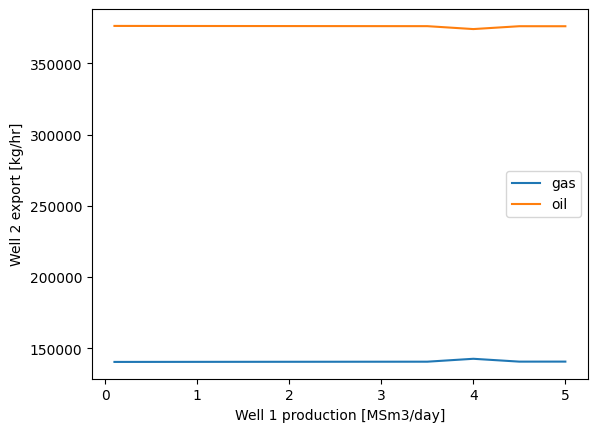

In [20]:
import matplotlib.pyplot as plt

well1production = [0.1, 0.5, 0.9, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
well2Gas = []
well2Oil = []

#set flow from well 2
oilprocess.getUnit('dry well stream2').setFlowRate(5.0, "MSm3/day")

for production in well1production:
  oilprocess.getUnit('dry well stream').setFlowRate(production, "MSm3/day")
  oilprocess.run()

  totalGasFlowFromWell2 = 0
  totalOilFlowFromWell2 = 0
  for name in componentNames:
    if(wellStream2.getFluid().getComponent(name).getz()>0):
      totalGasFlowFromWell2 = totalGasFlowFromWell2 + exportGas.getFluid().getComponent(name).getFlowRate('kg/hr')
      totalOilFlowFromWell2 = totalOilFlowFromWell2 + stableOil.getFluid().getComponent(name).getFlowRate('kg/hr')
  well2Gas.append(totalGasFlowFromWell2)
  well2Oil.append(totalOilFlowFromWell2)

plt.figure()
plt.xlabel('Well 1 production [MSm3/day]')
plt.ylabel('Well 2 export [kg/hr]')
plt.plot(well1production, well2Gas)
plt.plot(well1production, well2Oil)
plt.legend(['gas', 'oil'])

We see that when increasing the production of a well with high GOR (well 1), the the allocated oil production for the low GOR well (well 2) will decrease while gas allocation will increase.

A similar analysis could be done to see how different wells influence process capacity, power consumption and emissions for a field.

# Sending well stream 2 to the 2nd stage separator
IN the follwoing example we will see how ORF will be affected if we instead of sending both well stream 1 and well stream 2 to first stage (same ORF), but rather send well stream 1 to ast stage and well strem 2 to 2nd stage.

In [21]:
wellFluid = fluid('pr')
wellFluid.addComponent("nitrogen", 0.08)
wellFluid.addComponent("CO2", 3.56)
wellFluid.addComponent("methane", 87.36)
wellFluid.addComponent("ethane", 4.02)
wellFluid.addComponent("propane", 1.54)
wellFluid.addComponent("i-butane", 0.2)
wellFluid.addComponent("n-butane", 0.42)
wellFluid.addComponent("i-pentane", 0.15)
wellFluid.addComponent("n-pentane", 0.20)

wellFluid.addTBPfraction("C6", 3.24, 84.99/1000.0, 695.0/1000.0)
wellFluid.addTBPfraction("C7", 1.34, 97.87/1000.0, 718.0/1000.0)
wellFluid.addTBPfraction("C8", 1.33, 111.54/1000.0, 729.0/1000.0)
wellFluid.addTBPfraction("C9", 1.19, 126.1/1000.0, 749.0/1000.0)
wellFluid.addTBPfraction("C10", 1.15, 140.14/1000.0, 760.0/1000.0)
wellFluid.addTBPfraction("C11", 1.69, 175.0/1000.0, 830.0/1000.0)
wellFluid.addTBPfraction("C12", 1.5, 280.0/1000.0, 914.0/1000.0)
wellFluid.addTBPfraction("C13", 2.103, 560.0/1000.0, 980.0/1000.0)

names = wellFluid.getComponentNames()

for i in range(names.length):
  wellFluid.changeComponentName(wellFluid.getComponent(i).getName(), (wellFluid.getComponent(i).getName()+"__well1"))

wellFluid.addComponent("nitrogen", 0.08)
wellFluid.addComponent("CO2", 3.56)
wellFluid.addComponent("methane", 87.36)
wellFluid.addComponent("ethane", 4.02)
wellFluid.addComponent("propane", 1.54)
wellFluid.addComponent("i-butane", 0.2)
wellFluid.addComponent("n-butane", 0.42)
wellFluid.addComponent("i-pentane", 0.15)
wellFluid.addComponent("n-pentane", 0.20)

wellFluid.addTBPfraction("C6", 3.24, 82.99/1000.0, 695.0/1000.0)
wellFluid.addTBPfraction("C7", 1.34, 95.87/1000.0, 718.0/1000.0)
wellFluid.addTBPfraction("C8", 1.33, 121.54/1000.0, 729.0/1000.0)
wellFluid.addTBPfraction("C9", 1.19, 136.1/1000.0, 749.0/1000.0)
wellFluid.addTBPfraction("C10", 1.15, 150.14/1000.0, 760.0/1000.0)
wellFluid.addTBPfraction("C11", 1.69, 175.0/1000.0, 830.0/1000.0)
wellFluid.addTBPfraction("C12", 1.5, 310.0/1000.0, 914.0/1000.0)
wellFluid.addTBPfraction("C13", 2.103, 520.0/1000.0, 980.0/1000.0)

for i in range(names.length):
  wellFluid.changeComponentName(names[i], (wellFluid.getComponent(i).getName().replace("well1", "well2")))

wellFluid.setMixingRule('classic')

printFrame(wellFluid)


#and then set the fluid composition of the wells and run simulation

from neqsim.thermo import fluid, printFrame
from neqsim.process import compressor, cooler, separator3phase, getProcess, clearProcess, mixer, heater, stream, pump, separator, runProcess, stream, saturator, valve, filters, heatExchanger, simpleTEGAbsorber,distillationColumn, waterStripperColumn, recycle, setpoint, calculator

wellFluid.setMolarComposition([0.08, 3.56, 87.36, 4.02, 1.54, 0.2, 0.42, 0.15, 0.2, 1.24, 1.34, 1.33, 1.19, 1.15, 1.69, 1.5, 1.03,
                               0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


welFluid2 = wellFluid.clone()
welFluid2.setMolarComposition([ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                               0.08, 3.56, 45.36, 4.02, 1.54, 0.2, 0.42, 0.15, 0.2, 1.24, 1.34, 1.33, 1.19, 2.15, 2.69, 3.5, 1.03])

clearProcess()

wellStream = stream("dry well stream", wellFluid)
wellStream.setFlowRate(inputdata['feedFlowRateWellA'], "MSm3/day")
wellStream.setTemperature(inputdata['wellTemperature'], "C")
wellStream.setPressure(inputdata['wellPressure'], "bara")

wellStream2 = stream("dry well stream2", welFluid2)
wellStream2.setFlowRate(inputdata2['feedFlowRateWellB'], "MSm3/day")
wellStream2.setTemperature(inputdata['temperatureOilHeater'], "C")
wellStream2.setPressure(inputdata['secondStagePressure'], "bara")

wellmixer = mixer('mixer')
wellmixer.addStream(wellStream)
#wellmixer.addStream(wellStream2)

feedTPsetter = heater('inletTP', wellmixer.getOutletStream())
feedTPsetter.setOutPressure(inputdata['topsidePressure'], "bara")
feedTPsetter.setOutTemperature(inputdata['topsideTemperature'], "C")

chokeValve = valve('valve1', feedTPsetter.getOutStream())
chokeValve.setOutletPressure(inputdata['firstStagePressure'], 'bara')

feedToOffshoreProcess = stream("feed to offshore", chokeValve.getOutStream())

firstStageSeparator = separator3phase("1st stage separator", feedToOffshoreProcess)

oilHeaterFromFirstStage = heater("oil heater second stage", firstStageSeparator.getOilOutStream())
oilHeaterFromFirstStage.setOutTemperature(inputdata['temperatureOilHeater'],'C')

oilThrotValve = valve("valve oil from first stage", oilHeaterFromFirstStage.getOutStream())
oilThrotValve.setOutletPressure(inputdata['secondStagePressure'])

secondStageSeparator = separator3phase("2nd stage separator", oilThrotValve.getOutStream())
secondStageSeparator.addStream(wellStream2)

oilThrotValve2 = valve("valve oil from second stage", secondStageSeparator.getOilOutStream())
oilThrotValve2.setOutletPressure(inputdata['thirdStagePressure'])

thirdStageSeparator = separator3phase("3rd stage separator", oilThrotValve2.getOutStream())

oilThirdStageToSep =  wellStream.clone()
oilThirdStageToSep.setName("resyc oil")
thirdStageSeparator.addStream(oilThirdStageToSep)

stableOil = stream("stable oil", thirdStageSeparator.getOilOutStream())

stableOilPump = pump("stable oil pump", stableOil,15.0)

firstStageCooler = cooler("1st stage cooler", thirdStageSeparator.getGasOutStream())
firstStageCooler.setOutTemperature(inputdata['firstStageSuctionCoolerTemperature'],'C')

firstStageScrubber = separator("1st stage scrubber", firstStageCooler.getOutStream())

firstStageCompressor = compressor("1st stage compressor", firstStageScrubber.getGasOutStream())
firstStageCompressor.setOutletPressure(inputdata['secondStagePressure'])
firstStageCompressor.setIsentropicEfficiency(0.75)

firststGasMixer = mixer("first Stage mixer")
firststGasMixer.addStream(firstStageCompressor.getOutStream())
firststGasMixer.addStream(secondStageSeparator.getGasOutStream())

secondStageCooler = cooler("2nd stage cooler", firststGasMixer.getOutStream())
secondStageCooler.setOutTemperature(inputdata['secondStageSuctionCoolerTemperature'],'C')

secondStageScrubber = separator("2nd stage scrubber", secondStageCooler.getOutStream())

secondStageCompressor = compressor("2nd stage compressor", secondStageScrubber.getGasOutStream())
secondStageCompressor.setOutletPressure(inputdata['firstStagePressure'])
secondStageCompressor.setIsentropicEfficiency(0.75)

richGasMixer = mixer("fourth Stage mixer")
richGasMixer.addStream(secondStageCompressor.getOutStream())
richGasMixer.addStream(firstStageSeparator.getGasOutStream())

dewPointControlCooler = cooler("dew point cooler", richGasMixer.getOutStream())
dewPointControlCooler.setOutTemperature(inputdata['thirdStageSuctionCoolerTemperature'],'C')

dewPointScrubber = separator("dew point scrubber", dewPointControlCooler.getOutStream())

lpLiqmixer = mixer("LP liq gas mixer");
lpLiqmixer.addStream(firstStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(secondStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(dewPointScrubber.getLiquidOutStream());

lpResycle = recycle("LP liq resycle")
lpResycle.addStream(lpLiqmixer.getOutStream())
lpResycle.setOutletStream(oilThirdStageToSep)

exportCompressor1 = compressor("export 1st stage", dewPointScrubber.getGasOutStream())
exportCompressor1.setOutletPressure(140.0)
exportCompressor1.setIsentropicEfficiency(0.75)

exportInterstageCooler = cooler("interstage stage cooler", exportCompressor1.getOutStream())
exportInterstageCooler.setOutTemperature(inputdata['firstStageExportCoolerTemperature'],'C')

exportCompressor2= compressor("export 2nd stage", exportInterstageCooler.getOutStream())
exportCompressor2.setOutletPressure(200.0)
exportCompressor2.setIsentropicEfficiency(0.75)

exportCooler = cooler("export cooler", exportCompressor1.getOutStream())
exportCooler.setOutTemperature(inputdata['secondStageExportCoolerTemperature'],'C')

exportGas = stream("export gas", exportCooler.getOutStream())

oilprocess = getProcess()

| 0                    | 1          | 2          | 3          | 4   | 5   | 6               |
|:---------------------|:-----------|:-----------|:-----------|:----|:----|:----------------|
|                      | total      | GAS        | OIL        |     |     |                 |
| nitrogen__well1      | 3.60124E-4 | 3.60124E-4 | 3.60124E-4 |     |     | [mole fraction] |
| CO2__well1           | 1.60255E-2 | 1.60255E-2 | 1.60255E-2 |     |     | [mole fraction] |
| methane__well1       | 3.93255E-1 | 3.93255E-1 | 3.93255E-1 |     |     | [mole fraction] |
| ethane__well1        | 1.80962E-2 | 1.80962E-2 | 1.80962E-2 |     |     | [mole fraction] |
| propane__well1       | 6.93238E-3 | 6.93238E-3 | 6.93238E-3 |     |     | [mole fraction] |
| i-butane__well1      | 9.00309E-4 | 9.00309E-4 | 9.00309E-4 |     |     | [mole fraction] |
| n-butane__well1      | 1.89065E-3 | 1.89065E-3 | 1.89065E-3 |     |     | [mole fraction] |
| i-pentane__well1     | 6.75232E-4 | 6.75232E-4 | 6.75232E-

In [22]:
oilprocess.run()

In [23]:
TVP = stableOil.TVP(30.0, 'C')
cricondenbar = exportGas.CCB('bara')
gasexport = exportGas.getFlowRate('MSm3/day')
oilexport = stableOil.getFlowRate('m3/hr')

print('TVP [bara] ', TVP)
print('cricondenbar [bara] ', cricondenbar)
print('gas export [MSm3/day] ', gasexport)
print('oil export [m3/hr] ', oilexport)

TVP [bara]  1.0535269775774034
cricondenbar [bara]  65.62285414087063
gas export [MSm3/day]  12.9882191497662
oil export [m3/hr]  849.0289412932319


In [24]:
componentNames = wellStream.getFluid().getComponentNames()

print ('ORF factors.......................')
for name in componentNames:
  total = wellStream.getFluid().getComponent(name).getTotalFlowRate('kg/hr') + wellStream2.getFluid().getComponent(name).getTotalFlowRate('kg/hr')
  ORF = stableOil.getFluid().getComponent(name).getTotalFlowRate('kg/hr')/total
  print('ORF ', name, ' ', ORF)

ORF factors.......................
ORF  nitrogen__well1   6.794140178239817e-06
ORF  CO2__well1   0.0010484241111241403
ORF  methane__well1   0.00013421546177493174
ORF  ethane__well1   0.005077504420703867
ORF  propane__well1   0.04065637238174241
ORF  i-butane__well1   0.1227207202037567
ORF  n-butane__well1   0.1824168049893729
ORF  i-pentane__well1   0.3865343924458691
ORF  n-pentane__well1   0.4625657276159398
ORF  C6_PC__well1   0.7749902454154901
ORF  C7_PC__well1   0.916401233800724
ORF  C8_PC__well1   0.9739183106758189
ORF  C9_PC__well1   0.9923310528820286
ORF  C10_PC__well1   0.9972612575866393
ORF  C11_PC__well1   0.9997366939127033
ORF  C12_PC__well1   0.9999996982523949
ORF  C13_PC__well1   0.9999999999999795
ORF  nitrogen__well2   0.00026817074376332147
ORF  CO2__well2   0.006186933386838766
ORF  methane__well2   0.0017995671053222786
ORF  ethane__well2   0.018971812916088633
ORF  propane__well2   0.07976811381856706
ORF  i-butane__well2   0.18262254421302843
ORF  n-but

### Main Results

1. **Oil Recovery Factors (ORF):** The notebook calculates the ORF for each well, which represents the fraction of oil recovered from the well stream. The ORF values vary for different components, with heavier components generally having higher ORFs. For example, propane has a lower ORF, whereas heavier fractions (C6+) have higher ORFs. This indicates that more of the lighter components end up in the gas phase, while heavier components are primarily recovered in the oil phase.

2. **Impact of Well Production Rates:** The notebook demonstrates how changing the production rate of one well can affect the allocated oil and gas production of other wells. Specifically, increasing the production of a well with a high Gas-Oil Ratio (GOR) can decrease the allocated oil production for a well with a low GOR, while increasing its gas allocation. This highlights the importance of considering the interplay between wells when optimizing production.

3. **Allocation with Well Stream Routing:** The notebook explores how different well stream routing configurations can impact the allocation results. Sending a high-GOR well stream to the second-stage separator instead of the first-stage separator can influence the ORFs for different components and ultimately affect the overall allocation. This demonstrates the potential for optimizing allocation by carefully managing the flow of well streams within the process.